# Proyek Klasifikasi Gambar: [Input Nama Dataset]
- **Nama:** M. Eric Chaniago
- **Email:** akkitherythm@gmail.com
- **ID Dicoding:** m_ericchaniago_cddo

## Import Semua Packages/Library yang Digunakan

In [6]:
# Standard Library Imports
import os
import shutil
import zipfile
import random
import pathlib
import warnings
from pathlib import Path
from random import sample
import requests
from io import BytesIO
from urllib.request import urlopen

In [7]:
# Third-Party Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm as tq
import matplotlib.image as mpimg

In [8]:
# Image Processing Imports
import cv2
from PIL import Image
import skimage
from skimage import io
from skimage.transform import resize, rotate, AffineTransform, warp
from skimage import img_as_ubyte
from skimage.exposure import adjust_gamma
from skimage.util import random_noise

In [9]:
# Machine Learning & Deep Learning Imports
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers, callbacks
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import (
    ImageDataGenerator,
    img_to_array,
    load_img
)
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.layers import (
    InputLayer,
    Conv2D,
    SeparableConv2D,
    MaxPooling2D,
    MaxPool2D,
    Dense,
    Flatten,
    Dropout,
    BatchNormalization
)
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import (
    ModelCheckpoint,
    Callback,
    EarlyStopping,
    ReduceLROnPlateau
)


In [10]:
# Suppress warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Data Preparation

### Data Loading

In [11]:
# Import module
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"mericchaniago","key":"6d60837536727055a28b2b0b822b6615"}'}

In [12]:
# Download kaggle dataset and unzip the file
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.yjson

!kaggle datasets download -d vencerlanz09/plastic-paper-garbage-bag-synthetic-images
!unzip plastic-paper-garbage-bag-synthetic-images.zip -d dataset_folder

Streaming output truncated to the last 5000 lines.
  inflating: dataset_folder/ImageClassesCombinedWithCOCOAnnotations/images_raw/00010001.jpg  
  inflating: dataset_folder/ImageClassesCombinedWithCOCOAnnotations/images_raw/00010002.jpg  
  inflating: dataset_folder/ImageClassesCombinedWithCOCOAnnotations/images_raw/00010003.jpg  
  inflating: dataset_folder/ImageClassesCombinedWithCOCOAnnotations/images_raw/00010004.jpg  
  inflating: dataset_folder/ImageClassesCombinedWithCOCOAnnotations/images_raw/00010005.jpg  
  inflating: dataset_folder/ImageClassesCombinedWithCOCOAnnotations/images_raw/00010006.jpg  
  inflating: dataset_folder/ImageClassesCombinedWithCOCOAnnotations/images_raw/00010007.jpg  
  inflating: dataset_folder/ImageClassesCombinedWithCOCOAnnotations/images_raw/00010008.jpg  
  inflating: dataset_folder/ImageClassesCombinedWithCOCOAnnotations/images_raw/00010009.jpg  
  inflating: dataset_folder/ImageClassesCombinedWithCOCOAnnotations/images_raw/00010010.jpg  
  inflati

### Data Preprocessing

#### Split Dataset

In [13]:
# Splitting dataset (Train, Val, Test) with 80:10:10 ratio
dataset_path = 'dataset_folder/Bag Classes/Bag Classes'
base_output = 'dataset_split'

split_ratio = {
    'train': 0.8,
    'val': 0.1,
    'test': 0.1
}

# Create output directories
for split in ['train', 'val', 'test']:
    for class_name in os.listdir(dataset_path):
        class_split_path = os.path.join(base_output, split, class_name)
        os.makedirs(class_split_path, exist_ok=True)

# Process each class
for class_name in os.listdir(dataset_path):
    class_path = os.path.join(dataset_path, class_name)
    if os.path.isdir(class_path):
        all_images = os.listdir(class_path)
        random.shuffle(all_images)

        total = len(all_images)
        train_end = int(total * split_ratio['train'])
        val_end = train_end + int(total * split_ratio['val'])

        train_imgs = all_images[:train_end]
        val_imgs = all_images[train_end:val_end]
        test_imgs = all_images[val_end:]

        # Copy images to corresponding folders
        for img_list, split in zip([train_imgs, val_imgs, test_imgs], ['train', 'val', 'test']):
            for img in img_list:
                src = os.path.join(class_path, img)
                dst = os.path.join(base_output, split, class_name, img)
                shutil.copyfile(src, dst)

print("Dataset successfully split into train, val, and test.")

Dataset successfully split into train, val, and test.


In [14]:
# Set basic parameters
base_dir = 'dataset_split'
image_dimensions = (150, 150)
batch = 32

# Define paths for each dataset split
train_path = os.path.join(base_dir, 'train')
val_path = os.path.join(base_dir, 'val')
test_path = os.path.join(base_dir, 'test')

# Load training dataset
train_dataset = tf.keras.utils.image_dataset_from_directory(
    directory=train_path,
    image_size=image_dimensions,
    batch_size=batch,
    label_mode='categorical'
)

# Load validation dataset
validation_dataset = tf.keras.utils.image_dataset_from_directory(
    directory=val_path,
    image_size=image_dimensions,
    batch_size=batch,
    label_mode='categorical'
)

# Load testing dataset
test_dataset = tf.keras.utils.image_dataset_from_directory(
    directory=test_path,
    image_size=image_dimensions,
    batch_size=batch,
    label_mode='categorical'
)

Found 12000 files belonging to 3 classes.
Found 1500 files belonging to 3 classes.
Found 1500 files belonging to 3 classes.


#### Visualisasi Distribusi

In [15]:
# Function to count number of images in each class
def count_images_per_class(split_dir):
    counts = {}
    for class_name in os.listdir(split_dir):
        class_path = os.path.join(split_dir, class_name)
        if os.path.isdir(class_path):
            counts[class_name] = len(os.listdir(class_path))
    return counts

# Count images in each split
train_counts = count_images_per_class(train_path)
val_counts = count_images_per_class(val_path)
test_counts = count_images_per_class(test_path)

# Merge counts per class
all_classes = sorted(set(train_counts.keys()) | set(val_counts.keys()) | set(test_counts.keys()))

# Print table header
print(f"{'Class':<20} {'Train':<10} {'Val':<10} {'Test':<10} {'Total':<10}")
print('-' * 60)

# Print counts for each class
for class_name in all_classes:
    train_num = train_counts.get(class_name, 0)
    val_num = val_counts.get(class_name, 0)
    test_num = test_counts.get(class_name, 0)
    total_num = train_num + val_num + test_num
    print(f"{class_name:<20} {train_num:<10} {val_num:<10} {test_num:<10} {total_num:<10}")


Class                Train      Val        Test       Total     
------------------------------------------------------------
Garbage Bag Images   4000       500        500        5000      
Paper Bag Images     4000       500        500        5000      
Plastic Bag Images   4000       500        500        5000      


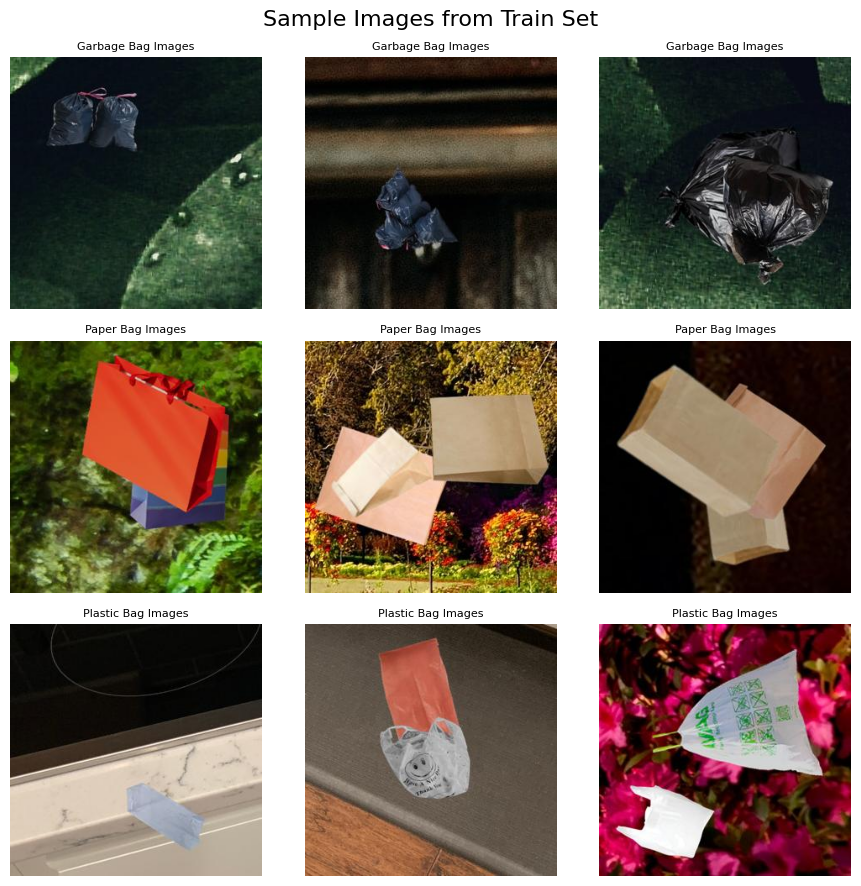

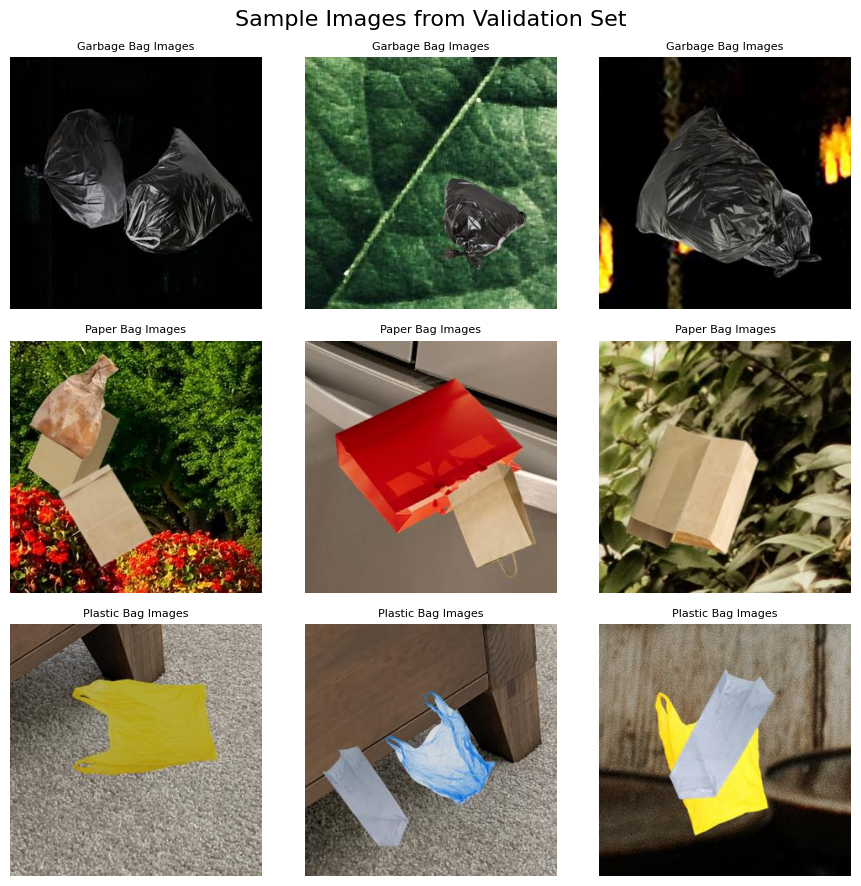

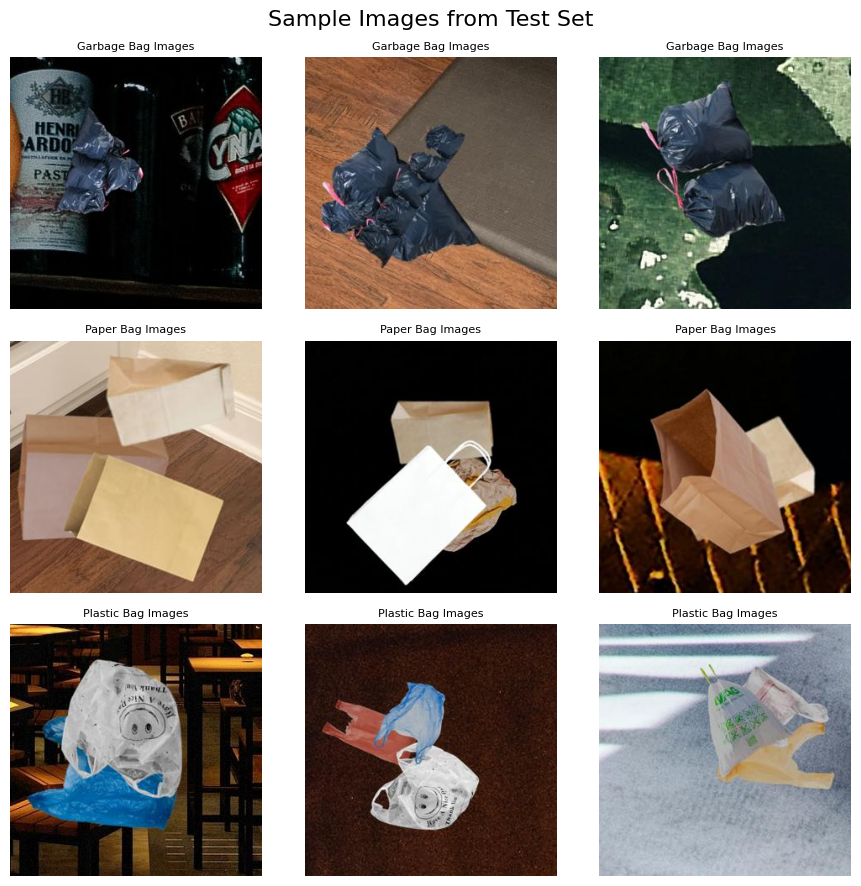

In [16]:
# Function to display sample images from each split
def display_samples(split_dir, split_name, samples_per_class=3):
    classes = sorted(os.listdir(split_dir))

    plt.figure(figsize=(samples_per_class * 3, len(classes) * 3))

    img_idx = 1
    for class_name in classes:
        class_path = os.path.join(split_dir, class_name)
        if os.path.isdir(class_path):
            images = os.listdir(class_path)
            selected_images = random.sample(images, min(samples_per_class, len(images)))

            for img_name in selected_images:
                img_path = os.path.join(class_path, img_name)
                img = mpimg.imread(img_path)

                plt.subplot(len(classes), samples_per_class, img_idx)
                plt.imshow(img)
                plt.axis('off')
                plt.title(f"{class_name}", fontsize=8)
                img_idx += 1

    plt.suptitle(f"Sample Images from {split_name} Set", fontsize=16)
    plt.tight_layout()
    plt.show()

# Show samples
display_samples(train_path, 'Train')
display_samples(val_path, 'Validation')
display_samples(test_path, 'Test')

## Modelling

#### Pre-modelling

In [17]:
# Data augmentation
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("both"),
    layers.RandomRotation(0.3),
    layers.RandomShear(0.3),
    layers.RandomContrast(0.2),
    layers.RandomZoom(0.1)
])

In [18]:
# Custom callback to stop training at 96% accuracy and val_accuracy
class EarlyStoppingAtAccuracy(Callback):
    def __init__(self, target_accuracy=0.96):
        super(EarlyStoppingAtAccuracy, self).__init__()
        self.target_accuracy = target_accuracy

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        val_accuracy = logs.get('val_accuracy')
        train_accuracy = logs.get('accuracy')

        if val_accuracy is not None and train_accuracy is not None:
            if val_accuracy >= self.target_accuracy and train_accuracy >= self.target_accuracy:
                print(f"\nReached {self.target_accuracy*100}% accuracy and val_accuracy. Stopping training!")
                self.model.stop_training = True

# Create the callback
early_stopping_callback = EarlyStoppingAtAccuracy(target_accuracy=0.96)


#### Model Architecture

In [19]:
model = models.Sequential([
    data_augmentation,
    layers.Rescaling(1./255, input_shape=(150, 150, 3)),

    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D(),

    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D(),

    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D(),

    layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D(),

    layers.Dropout(0.4),
    layers.Flatten(),

    layers.Dense(256, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(3, activation='softmax')
])


model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [29]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 150, 150, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 75, 75, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 37, 37, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 37, 37, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 18, 18, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 18, 18, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 9, 9, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 9, 9, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 20736)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     5,308,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,093,579 (65.21 MB)

 Trainable params: 5,697,859 (21.74 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 11,395,720 (43.47 MB)

#### Model Training

In [21]:
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=30,
    callbacks=[early_stopping_callback]
)

Epoch 1/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 26s 46ms/step - accuracy: 0.6535 - loss: 0.7325 - val_accuracy: 0.8820 - val_loss: 0.3267
Epoch 2/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 35s 45ms/step - accuracy: 0.8878 - loss: 0.3110 - val_accuracy: 0.9180 - val_loss: 0.2414
Epoch 3/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 20s 44ms/step - accuracy: 0.9081 - loss: 0.2606 - val_accuracy: 0.9113 - val_loss: 0.2727
Epoch 4/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9176 - loss: 0.2234 - val_accuracy: 0.9287 - val_loss: 0.1947
Epoch 5/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 18s 48ms/step - accuracy: 0.9335 - loss: 0.1868 - val_accuracy: 0.9447 - val_loss: 0.1635
Epoch 6/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - accuracy: 0.9358 - loss: 0.1886 - val_accuracy: 0.9380 - val_loss: 0.2276
Epoch 7/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 18s 48ms/step - accuracy: 0.9448 - loss: 0.1632 - val_accuracy: 0.9507 - val_loss: 0.1291
Epoch 8/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 19s 44ms/step - accuracy: 0.9488 - loss: 0.1425 - 

## Evaluasi dan Visualisasi

In [22]:
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Akurasi di test set: {test_acc:.2%}")

47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9666 - loss: 0.1021
Akurasi di test set: 96.73%


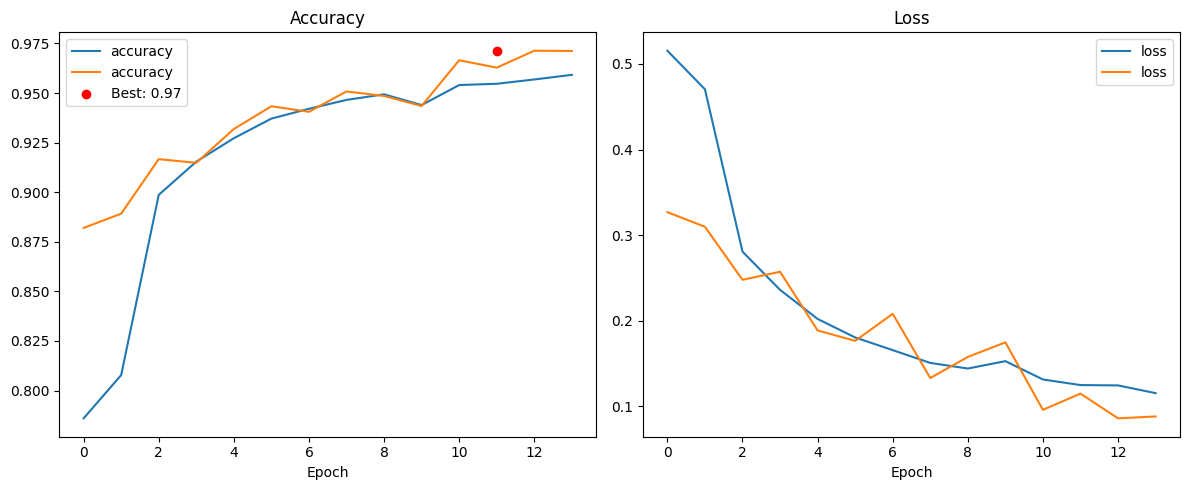

In [23]:
# Smooth data with exponential moving average
smooth = lambda y, α=0.8: [y[0]] + [α*y[i-1] + (1-α)*y[i] for i in range(1, len(y))]

h = history.history
epoch = np.argmax(h['val_accuracy'])

plt.figure(figsize=(12, 5))

for i, (metrics, title) in enumerate(zip(
    [('accuracy', 'val_accuracy'), ('loss', 'val_loss')],
    ['Accuracy', 'Loss']
)):
    plt.subplot(1, 2, i+1)
    for m in metrics:
        plt.plot(smooth(h[m]), label=m.split('_')[-1])
    if i == 0:
        plt.scatter(epoch, h['val_accuracy'][epoch], c='r',
                   label=f'Best: {h["val_accuracy"][epoch]:.2f}')
    plt.title(title); plt.xlabel('Epoch'); plt.legend()

plt.tight_layout()
plt.show()

## Konversi Model

In [24]:
!pip install tensorflowjs
model.save("model.h5")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 5.3 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-cloud-bigquery 3.31.0 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.


#### Konversi TFJS

In [25]:
!tensorflowjs_converter --input_format=keras model.h5 tfjs_model

2025-04-27 12:13:19.960953: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745755999.979962    2951 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745755999.985783    2951 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
🌲 Try https://ydf.readthedocs.io, the successor of TensorFlow Decision Forests with more features and faster training!
failed to lookup keras version from the file,
    this is likely a weight only file


#### Konversi Save Model

In [26]:
# Save model in SavedModel format
saved_model_dir = 'saved_model'
os.makedirs(saved_model_dir, exist_ok=True)
model.export(saved_model_dir)
print("Model successfully saved in SavedModel format.")

Saved artifact at 'saved_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  139845837480464: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139845837480656: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139845837481424: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139845837480272: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139845837481232: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139845478056208: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139845478059664: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139845478061008: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139845478061968: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139845478061776: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139845478062736: Te

#### Konversi TFLite

In [27]:
# Konversi ke TFLite
converter = tf.lite.TFLiteConverter.from_saved_model("saved_model")
converter.experimental_new_converter = True  # Enable the new MLIR-based converter if available.
converter.target_spec.supported_ops = [
  tf.lite.OpsSet.TFLITE_BUILTINS, # enable TensorFlow Lite ops.
  tf.lite.OpsSet.SELECT_TF_OPS # enable TensorFlow ops.
]
tflite_model = converter.convert()

# Simpan model.tflite
os.makedirs("tflite", exist_ok=True)
with open("tflite/model.tflite", "wb") as f:
    f.write(tflite_model)

# Simpan label.txt jika ada label
labels = ["Plastic Bag Images", "Paper Bag Images", "Garbage Bag Images"]
with open("tflite/label.txt", "w") as f:
    for label in labels:
        f.write(label + "\n")

#### Compress

In [28]:
!zip -r all_converted_model.zip saved_model tfjs_model tflite
files.download("all_converted_model.zip")

  adding: saved_model/ (stored 0%)
  adding: saved_model/variables/ (stored 0%)
  adding: saved_model/variables/variables.data-00000-of-00001 (deflated 7%)
  adding: saved_model/variables/variables.index (deflated 66%)
  adding: saved_model/saved_model.pb (deflated 89%)
  adding: saved_model/assets/ (stored 0%)
  adding: saved_model/fingerprint.pb (stored 0%)
  adding: tfjs_model/ (stored 0%)
  adding: tfjs_model/group1-shard4of6.bin (deflated 7%)
  adding: tfjs_model/group1-shard2of6.bin (deflated 7%)
  adding: tfjs_model/group1-shard6of6.bin (deflated 7%)
  adding: tfjs_model/group1-shard5of6.bin (deflated 7%)
  adding: tfjs_model/group1-shard3of6.bin (deflated 7%)
  adding: tfjs_model/group1-shard1of6.bin (deflated 7%)
  adding: tfjs_model/model.json (deflated 87%)
  adding: tflite/ (stored 0%)
  adding: tflite/model.tflite (deflated 7%)
  adding: tflite/label.txt (deflated 36%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Inference (Optional)

In [55]:
model = tf.saved_model.load("saved_model")

In [30]:
# upload gambar yang ingin diprediksi
from google.colab import files
uploaded = files.upload()

Saving images (1).jpeg to images (1).jpeg


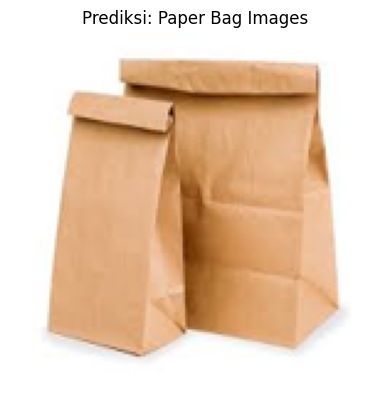

In [32]:
# Load TFLite model
interpreter = tf.lite.Interpreter(model_path="tflite/model.tflite")
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Preprocessing sama kayak tadi
image_path = list(uploaded.keys())[0]
img = Image.open(image_path).convert('RGB')
# Resize the image to match the model's input size
img = img.resize((150, 150)) # Changed the resize dimensions to (150, 150)
img_array = np.array(img, dtype=np.float32) / 255.0
img_array = np.expand_dims(img_array, axis=0)

# Set input tensor
interpreter.set_tensor(input_details[0]['index'], img_array)
interpreter.invoke()

# Ambil hasil output
output = interpreter.get_tensor(output_details[0]['index'])
predicted_class = np.argmax(output)
# Ensure label_names is defined and accessible
# Assuming label_names is defined elsewhere, you might need to replace this with your actual label names
label_names = ["Plastic Bag Images", "Paper Bag Images", "Garbage Bag Images"]
predicted_label = label_names[predicted_class]

# Tampilkan gambar + prediksi
plt.imshow(img)
plt.title(f"Prediksi: {predicted_label}")
plt.axis('off')
plt.show()